In [1]:
# command line install
!conda install -y -c conda-forge xgboost

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.14.0
  latest version: 22.9.0

Please update conda by running

    $ conda update -n base -c conda-forge conda



# All requested packages already installed.

Retrieving notices: ...working... done


In [2]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn import naive_bayes 
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import linear_model, decomposition, datasets
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
 

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import roc_curve, auc

In [4]:
df_original = pd.read_csv('train.tsv', sep='\t')
df=df_original.copy()

# Data Cleaning

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7395 entries, 0 to 7394
Data columns (total 27 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   url                             7395 non-null   object 
 1   urlid                           7395 non-null   int64  
 2   boilerplate                     7395 non-null   object 
 3   alchemy_category                7395 non-null   object 
 4   alchemy_category_score          7395 non-null   object 
 5   avglinksize                     7395 non-null   float64
 6   commonlinkratio_1               7395 non-null   float64
 7   commonlinkratio_2               7395 non-null   float64
 8   commonlinkratio_3               7395 non-null   float64
 9   commonlinkratio_4               7395 non-null   float64
 10  compression_ratio               7395 non-null   float64
 11  embed_ratio                     7395 non-null   float64
 12  framebased                      73

### Checking for duplicates

In [6]:
#number of unique id's

In [7]:
df.urlid.nunique()

7395

In [8]:
#number of unique urls
df.url.nunique()

7395

In [9]:
len(df)-len(df.drop_duplicates())

0

### Checking for null values

In [10]:
df.isna().values.any()

False

### Renaming Target

In [11]:
df=df.rename(columns={'label':'is_evergreen'})

### Inspecting data types

In [12]:
df.dtypes

url                                object
urlid                               int64
boilerplate                        object
alchemy_category                   object
alchemy_category_score             object
avglinksize                       float64
commonlinkratio_1                 float64
commonlinkratio_2                 float64
commonlinkratio_3                 float64
commonlinkratio_4                 float64
compression_ratio                 float64
embed_ratio                       float64
framebased                          int64
frameTagRatio                     float64
hasDomainLink                       int64
html_ratio                        float64
image_ratio                       float64
is_news                            object
lengthyLinkDomain                   int64
linkwordscore                       int64
news_front_page                    object
non_markup_alphanum_characters      int64
numberOfLinks                       int64
numwords_in_url                   

In [13]:
def Featurize(df_train):
    U1 = df_train['url'].str.split('//',n = -1, expand = True)[1]
    U2 = U1.str.split('www.',n = -1, expand = True)[1]
    webname = U2.str.split('.',n = -1, expand = True)[0]
    U3 = U2.str.split('.',n = -1, expand = True)[1]
    domain = U3.str.split('/',n = -1, expand = True)[0]
    website_type = U3.str.split('/',n = -1, expand = True)[1]
    U4 = U3.str.split('/',n = -1, expand = True)[2]
    website_type2 = U4.str.split('/',n = -1, expand = True)[0]

    ###================= Categorical Features out of this ======
    df_train["website"] = webname
    df_train["website_type"] = website_type
    df_train["website_type2"] = website_type2
    df_train["domain"] = domain 
    
    return df_train

In [14]:
def website(url):
        if len(url.split('/')[2].split('.'))<=2 and url.split('/')[2].split('.')[0]!='www':
            return url.split('/')[2].split('.')[0]
        
        else:
            return url.split('/')[2].split('.')[1]
        

In [15]:
df['website']=df.url.apply(lambda x:website(x))

In [16]:
website_count=df.website.value_counts()

In [17]:
other_w_c=list(website_count[website_count<=30].index)

In [18]:
df['website']=df['website'].replace(other_w_c,'other')

In [19]:
#Looks like is_news and news_front_page should be numerical, let's inspect

In [20]:
#is_news has a "?" value that corresponds to 0

In [21]:
df.is_news.value_counts()

1    4552
?    2843
Name: is_news, dtype: int64

In [22]:
#it looks like these url's are not news,let's replace '?' with 0

In [23]:
df[df.is_news=='?'].url

5       http://www.conveniencemedical.com/genital-herp...
7       http://www.insidershealth.com/article/racing_f...
9       http://www.howsweeteats.com/2010/03/24/cookies...
11      http://www.midwestsportsfans.com/2010/12/photo...
13      http://www.thedailygreen.com/print-this/health...
                              ...                        
7385    http://shopmarkethq.com/collections/brands-min...
7386    http://slice.seriouseats.com/archives/2010/06/...
7389    http://www.worth1000.com/emailthis.asp?entry=5...
7392    http://eatthis.menshealth.com/slide/sweet-pota...
7394    http://sportsillustrated.cnn.com/2011_swimsuit...
Name: url, Length: 2843, dtype: object

In [24]:
df['is_news']=df.is_news.replace('?',0)

In [25]:
#let's look at news front page,'?' are values that are not identified, let's
#leave as is for now and treat as a categorical later 
df.news_front_page.value_counts()

0    5853
?    1248
1     294
Name: news_front_page, dtype: int64

In [26]:
#Making both columns into numerical columns

In [27]:
df=df.astype({'is_news': 'int64'})

In [28]:
df.dtypes

url                                object
urlid                               int64
boilerplate                        object
alchemy_category                   object
alchemy_category_score             object
avglinksize                       float64
commonlinkratio_1                 float64
commonlinkratio_2                 float64
commonlinkratio_3                 float64
commonlinkratio_4                 float64
compression_ratio                 float64
embed_ratio                       float64
framebased                          int64
frameTagRatio                     float64
hasDomainLink                       int64
html_ratio                        float64
image_ratio                       float64
is_news                             int64
lengthyLinkDomain                   int64
linkwordscore                       int64
news_front_page                    object
non_markup_alphanum_characters      int64
numberOfLinks                       int64
numwords_in_url                   

### Dropping columns that are not relevant to the analysis

In [29]:
#at a glance url_id can be removed,framebased has only one value, so it can also be dropped,other columns
#like

In [30]:
df.framebased.unique()

array([0])

In [31]:
df=df.drop(columns=['framebased','urlid'])

In [32]:
df.head()

,url,boilerplate,alchemy_category,alchemy_category_score,avglinksize,commonlinkratio_1,commonlinkratio_2,commonlinkratio_3,commonlinkratio_4,compression_ratio,...,lengthyLinkDomain,linkwordscore,news_front_page,non_markup_alphanum_characters,numberOfLinks,numwords_in_url,parametrizedLinkRatio,spelling_errors_ratio,is_evergreen,website
0,http://www.bloomberg.com/news/2010-12-23/ibm-p...,"{""title"":""IBM Sees Holographic Calls Air Breat...",business,0.789131,2.055556,0.676471,0.205882,0.047059,0.023529,0.443783,...,1,24,0,5424,170,8,0.152941,0.079130,0,other
1,http://www.popsci.com/technology/article/2012-...,"{""title"":""The Fully Electronic Futuristic Star...",recreation,0.574147,3.677966,0.508021,0.288770,0.213904,0.144385,0.468649,...,1,40,0,4973,187,9,0.181818,0.125448,1,popsci
2,http://www.menshealth.com/health/flu-fighting-...,"{""title"":""Fruits that Fight the Flu fruits tha...",health,0.996526,2.382883,0.562016,0.321705,0.120155,0.042636,0.525448,...,1,55,0,2240,258,11,0.166667,0.057613,1,menshealth
3,http://www.dumblittleman.com/2007/12/10-foolpr...,"{""title"":""10 Foolproof Tips for Better Sleep ""...",health,0.801248,1.543103,0.400000,0.100000,0.016667,0.000000,0.480725,...,0,24,0,2737,120,5,0.041667,0.100858,1,other
4,http://bleacherreport.com/articles/1205138-the...,"{""title"":""The 50 Coolest Jerseys You Didn t Kn...",sports,0.719157,2.676471,0.500000,0.222222,0.123457,0.043210,0.446143,...,1,14,0,12032,162,10,0.098765,0.082569,0,bleacherreport


# Feature Selection & Baseline Models 

### First Subset with Numerical Features

In [33]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df_num= df.select_dtypes(include=numerics)

In [34]:
df_num.columns

Index(['avglinksize', 'commonlinkratio_1', 'commonlinkratio_2',
       'commonlinkratio_3', 'commonlinkratio_4', 'compression_ratio',
       'embed_ratio', 'frameTagRatio', 'hasDomainLink', 'html_ratio',
       'image_ratio', 'is_news', 'lengthyLinkDomain', 'linkwordscore',
       'non_markup_alphanum_characters', 'numberOfLinks', 'numwords_in_url',
       'parametrizedLinkRatio', 'spelling_errors_ratio', 'is_evergreen'],
      dtype='object')

In [35]:
#sns.pairplot(df_num,hue='is_evergreen')

In [36]:
#let's drop embed_ratio,hasDomainLink,lengthyLinkDomain,commonlinkratio_1
from sklearn.model_selection import KFold

In [37]:
y=df_num['is_evergreen']
X=df_num.drop(columns=['is_evergreen','embed_ratio','hasDomainLink','lengthyLinkDomain','commonlinkratio_1'])

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.2, random_state=42)

In [39]:

std_scale = StandardScaler()

X_train_scaled = std_scale.fit_transform(X_train)
X_test_scaled = std_scale.fit_transform(X_test)

logit = LogisticRegression(C = 0.05,penalty='l2') 


In [40]:
val_accuracy = cross_val_score(logit, X_train_scaled, y_train, cv=5, scoring='accuracy')
val_precision=cross_val_score(logit, X_train_scaled, y_train, cv=5, scoring='precision')
val_recall=cross_val_score(logit, X_train_scaled, y_train, cv=5, scoring='recall')
val_f1=cross_val_score(logit, X_train_scaled, y_train, cv=5, scoring='f1')
val_roc_auc=cross_val_score(logit, X_train_scaled, y_train, cv=5, scoring='roc_auc')
print("The accuracy score for Logistic Regression is")
print("Validation: {:6.2f}%".format(100*val_accuracy.mean()))
print("Validation Recall: {:6.2f}%".format(100*val_recall.mean()))
print("Validation Precison: {:6.2f}%".format(100*val_precision.mean()))
print("Validation F1: {:6.2f}%".format(100*val_f1.mean()))
print("Validation ROC_AUC: {:6.2f}%".format(100*val_roc_auc.mean()))

The accuracy score for Logistic Regression is
Validation:  62.07%
Validation Recall:  71.84%
Validation Precison:  61.24%
Validation F1:  66.11%
Validation ROC_AUC:  66.56%


In [41]:
logit.fit(X_train_scaled, y_train)

print("The score for logistic regression is")
print("Training: {:6.2f}%".format(100*logit.score(X_train_scaled, y_train)))
print("Test set: {:6.2f}%".format(100*logit.score(X_test_scaled, y_test)))
print("Logistic regression confusion matrix: \n\n", confusion_matrix(y_test, logit.predict(X_test_scaled)))
y_predict = logit.predict(X_test_scaled)
print("Default threshold:")
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_test, y_predict), 
                                                     recall_score(y_test, y_predict)))
print(f1_score(y_test, y_predict))
print("ROC AUC score = ", roc_auc_score(y_test, logit.predict_proba(X_test_scaled)[:,1]))

The score for logistic regression is
Training:  62.37%
Test set:  61.46%
Logistic regression confusion matrix: 

 [[375 355]
 [215 534]]
Default threshold:
Precision: 0.6007,   Recall: 0.7130
0.652014652014652
ROC AUC score =  0.6625290341459846


In [42]:
X1_train=X_train_scaled 
X1_test=X_test_scaled 

In [43]:
y1_train=y_train
y1_test=y_test

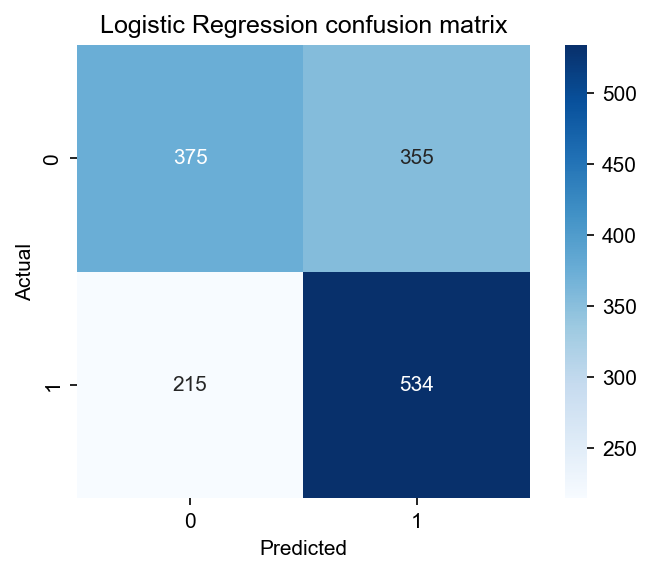

In [44]:
logit_confusion = confusion_matrix(y_test, logit.predict(X_test_scaled))
plt.figure(dpi=150)
sns.heatmap(logit_confusion, cmap=plt.cm.Blues, annot=True, square=True,fmt="d")
sns.set(font_scale=1)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Logistic Regression confusion matrix');

In [45]:
'''from sklearn.feature_selection import mutual_info_classif
mutual_info=mutual_info_classif(X_train_scaled,y_train)
mutual_info=pd.Series(mutual_info)
mutual_info.index=X_train.columns
mutual_info.sort_values()'''

'from sklearn.feature_selection import mutual_info_classif\nmutual_info=mutual_info_classif(X_train_scaled,y_train)\nmutual_info=pd.Series(mutual_info)\nmutual_info.index=X_train.columns\nmutual_info.sort_values()'

In [46]:
(list(X_train.columns),logit.coef_.tolist())

(['avglinksize',
  'commonlinkratio_2',
  'commonlinkratio_3',
  'commonlinkratio_4',
  'compression_ratio',
  'frameTagRatio',
  'html_ratio',
  'image_ratio',
  'is_news',
  'linkwordscore',
  'non_markup_alphanum_characters',
  'numberOfLinks',
  'numwords_in_url',
  'parametrizedLinkRatio',
  'spelling_errors_ratio'],
 [[-0.020443219038134373,
   0.08060372209807835,
   0.27899228687633115,
   -0.13611457605049684,
   0.00122808017755938,
   -0.28783583165575155,
   -0.002324376905877766,
   -0.027905016189789227,
   0.010401396181632569,
   -0.480312824418476,
   -0.17204081107250502,
   0.1626764504109323,
   -0.07826223496395268,
   -0.01004627568686858,
   -0.09843935399550521]])

In [47]:
list(X_train.columns)

['avglinksize',
 'commonlinkratio_2',
 'commonlinkratio_3',
 'commonlinkratio_4',
 'compression_ratio',
 'frameTagRatio',
 'html_ratio',
 'image_ratio',
 'is_news',
 'linkwordscore',
 'non_markup_alphanum_characters',
 'numberOfLinks',
 'numwords_in_url',
 'parametrizedLinkRatio',
 'spelling_errors_ratio']

In [48]:
features=list(X_train.columns)
coef=[-0.020443219038134373,
  0.08060372209807835,
  0.27899228687633115,
  -0.13611457605049684,
  0.00122808017755938,
  -0.28783583165575155,
  -0.002324376905877766,
  -0.027905016189789227,
  0.010401396181632569,
  -0.480312824418476,
  -0.17204081107250502,
  0.1626764504109323,
  -0.07826223496395268,
  -0.01004627568686858,
  -0.09843935399550521]

In [49]:
dico={}
for i in range(0,13):
    dico[features[i]]=coef[i]

In [50]:
coef_= (pd.DataFrame.from_dict(dico,orient='index')).reset_index()

In [51]:
coef_=coef_.rename(columns={'index':'Feature',0:'Coefficient'})

In [52]:
coef_=coef_.sort_values('Coefficient')

In [53]:
#sns.set(context='notebook', style='whitegrid', font_scale=2)

In [54]:
plt.figure(1,figsize=(18,8),dpi=1200)
fig = sns.barplot(x=coef_['Coefficient'], y=coef_['Feature'], palette="icefire")
fig.set(xlabel='Coefficients',ylabel='',title = 'Features Relationship with Price')
plt.savefig("myimage4.eps", dpi=1200)

In [55]:
plt.savefig("myimage4.eps", dpi=1200)

<Figure size 432x288 with 0 Axes>

### Dropping features based on really small coefficients with L2: compression ratio and image ratio

In [56]:
X=X.drop(columns=['compression_ratio','image_ratio'])
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.2, random_state=42)

std_scale = StandardScaler()

X_train_scaled = std_scale.fit_transform(X_train)
X_test_scaled = std_scale.fit_transform(X_test)

In [57]:
logit2 = LogisticRegression(C = 0.05,penalty='l2') 

In [58]:
val_accuracy = cross_val_score(logit2, X_train_scaled, y_train, cv=5, scoring='accuracy')
val_precision=cross_val_score(logit2, X_train_scaled, y_train, cv=5, scoring='precision')
val_recall=cross_val_score(logit2, X_train_scaled, y_train, cv=5, scoring='recall')
val_f1=cross_val_score(logit2, X_train_scaled, y_train, cv=5, scoring='f1')
val_roc_auc=cross_val_score(logit2, X_train_scaled, y_train, cv=5, scoring='roc_auc')
print("The accuracy score for Logistic Regression is")
print("Validation: {:6.2f}%".format(100*val_accuracy.mean()))
print("Validation Recall: {:6.2f}%".format(100*val_recall.mean()))
print("Validation Precison: {:6.2f}%".format(100*val_precision.mean()))
print("Validation F1: {:6.2f}%".format(100*val_f1.mean()))
print("Validation ROC_AUC: {:6.2f}%".format(100*val_roc_auc.mean()))

The accuracy score for Logistic Regression is
Validation:  62.22%
Validation Recall:  71.84%
Validation Precison:  61.40%
Validation F1:  66.20%
Validation ROC_AUC:  66.59%


In [59]:
logit2.fit(X_train_scaled, y_train)

print("The score for logistic regression is")
print("Training: {:6.2f}%".format(100*logit2.score(X_train_scaled, y_train)))
print("Test set: {:6.2f}%".format(100*logit2.score(X_test_scaled, y_test)))
print("Logistic regression confusion matrix: \n\n", confusion_matrix(y_test, logit2.predict(X_test_scaled)))
y_predict = logit2.predict(X_train_scaled)
print("Default threshold:")
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_train, y_predict), 
                                                     recall_score(y_train, y_predict)))
print(f1_score(y_train, y_predict))
print("ROC AUC score = ", roc_auc_score(y_train, logit2.predict_proba(X_train_scaled)[:,1]))

The score for logistic regression is
Training:  62.46%
Test set:  61.53%
Logistic regression confusion matrix: 

 [[376 354]
 [215 534]]
Default threshold:
Precision: 0.6154,   Recall: 0.7227
0.6647547169811321
ROC AUC score =  0.6691093628654736


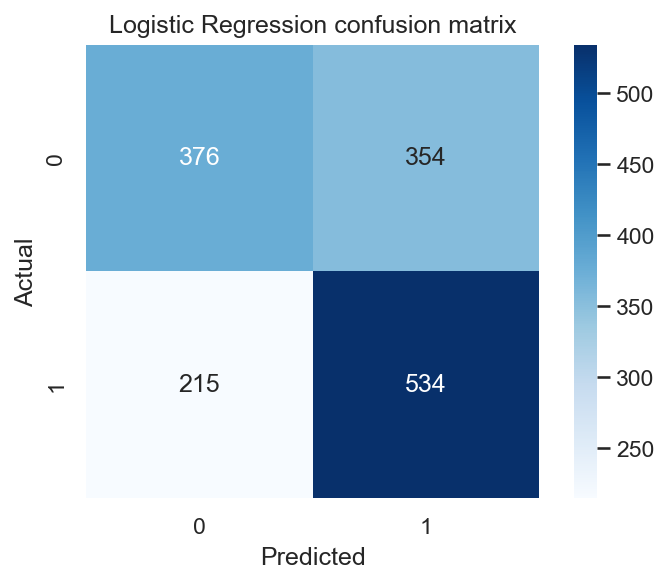

In [60]:

sns.set(font_scale=1)
logit_confusion = confusion_matrix(y_test, logit2.predict(X_test_scaled))
plt.figure(dpi=150)
sns.heatmap(logit_confusion, cmap=plt.cm.Blues, annot=True, square=True,fmt="d")

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Logistic Regression confusion matrix');

### KNN

In [61]:
knn = KNeighborsClassifier()
# define the parameter values that should be searched
k_range = list(range(1, 200))
# create a parameter grid: map the parameter names to the values that should be searched
param_grid = dict(n_neighbors=k_range)

In [62]:
# instantiate the grid
grid = GridSearchCV(knn, param_grid, cv=5, scoring='roc_auc')
grid.fit(X_train_scaled, y_train)
print("Best params: ", grid.best_params_)
print("Best estimator: ", grid.best_estimator_)
print("Best score: ", grid.best_score_)

Best params:  {'n_neighbors': 18}
Best estimator:  KNeighborsClassifier(n_neighbors=18)
Best score:  0.6931975145508152


In [63]:
knn = KNeighborsClassifier(n_neighbors=18)
val_accuracy = cross_val_score(knn, X_train_scaled, y_train, cv=5, scoring='accuracy')
val_precision=cross_val_score(knn, X_train_scaled, y_train, cv=5, scoring='precision')
val_recall=cross_val_score(knn, X_train_scaled, y_train, cv=5, scoring='recall')
val_f1=cross_val_score(knn, X_train_scaled, y_train, cv=5, scoring='f1')
val_roc_auc=cross_val_score(knn, X_train_scaled, y_train, cv=5, scoring='roc_auc')
print("The accuracy score for KNN is")
print("Validation Accuracy: {:6.2f}%".format(100*val_accuracy.mean()))
print("Validation Recall: {:6.2f}%".format(100*val_recall.mean()))
print("Validation Precison: {:6.2f}%".format(100*val_precision.mean()))
print("Validation F1: {:6.2f}%".format(100*val_f1.mean()))
print("Validation ROC_AUC: {:6.2f}%".format(100*val_roc_auc.mean()))

The accuracy score for KNN is
Validation Accuracy:  63.73%
Validation Recall:  66.13%
Validation Precison:  64.38%
Validation F1:  65.23%
Validation ROC_AUC:  69.32%


In [64]:
knn.fit(X_train_scaled,y_train)
print("The accuracy score for knn is")
print("Training: {:6.2f}%".format(100*knn.score(X_train_scaled, y_train)))
print("Test set: {:6.2f}%".format(100*knn.score(X_test_scaled, y_test)))
print("Logistic regression confusion matrix: \n\n", confusion_matrix(y_test, knn.predict(X_test_scaled)))
y_predict = knn.predict(X_train_scaled)
print("Default threshold:")
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_train, y_predict), 
                                                     recall_score(y_train, y_predict)))
print(f1_score(y_train, y_predict))
print("ROC AUC score = ", roc_auc_score(y_train, knn.predict_proba(X_train_scaled)[:,1]))

The accuracy score for knn is
Training:  68.27%
Test set:  62.00%
Logistic regression confusion matrix: 

 [[427 303]
 [259 490]]
Default threshold:
Precision: 0.6854,   Recall: 0.7099
0.6974044817024021
ROC AUC score =  0.7585680731168474


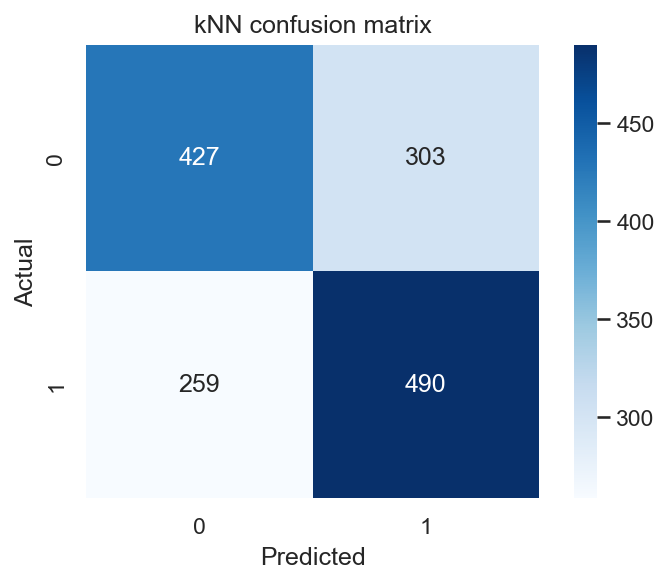

In [65]:
knn_confusion = confusion_matrix(y_test, knn.predict(X_test_scaled))
plt.figure(dpi=150)
sns.heatmap(knn_confusion, cmap=plt.cm.Blues, annot=True, square=True,fmt="d")

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('kNN confusion matrix');

### Decision Tree

In [66]:


decisiontree = DecisionTreeClassifier()
val_accuracy = cross_val_score(decisiontree , X_train, y_train, cv=5, scoring='accuracy')
val_precision=cross_val_score(decisiontree , X_train, y_train, cv=5, scoring='precision')
val_recall=cross_val_score(decisiontree , X_train, y_train, cv=5, scoring='recall')
val_f1=cross_val_score(decisiontree , X_train, y_train, cv=5, scoring='f1')
val_roc_auc=cross_val_score(decisiontree , X_train, y_train, cv=5, scoring='roc_auc')
print("The accuracy score for Decision Tree is")
print("Validation Accuracy: {:6.2f}%".format(100*val_accuracy.mean()))
print("Validation Recall: {:6.2f}%".format(100*val_recall.mean()))
print("Validation Precison: {:6.2f}%".format(100*val_precision.mean()))
print("Validation F1: {:6.2f}%".format(100*val_f1.mean()))
print("Validation ROC_AUC: {:6.2f}%".format(100*val_roc_auc.mean()))



The accuracy score for Decision Tree is
Validation Accuracy:  59.45%
Validation Recall:  61.47%
Validation Precison:  60.43%
Validation F1:  61.03%
Validation ROC_AUC:  59.95%


Text(0.5, 1.0, 'Decision Tree confusion matrix')

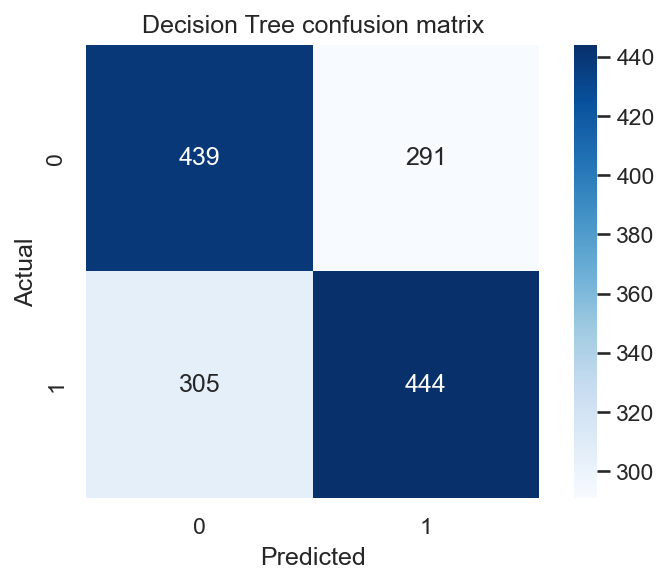

In [67]:
decisiontree.fit(X_train,y_train)
decision_tree_confusion = confusion_matrix(y_test, decisiontree.predict(X_test))
plt.figure(dpi=150)
sns.heatmap(decision_tree_confusion, cmap=plt.cm.Blues, annot=True, square=True,fmt="d")

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Decision Tree confusion matrix')

### Random Forest

In [68]:
'''max_depth=[10,12]
n_estimators = [1000,2000]
max_features=[5,6]
min_samples_split=[4,6]
bootstrap=[True,False]
criterion=['gini','entropy']
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators,max_features=max_features,min_samples_split=min_samples_split,\
                 bootstrap=bootstrap,criterion=criterion)

# Build the grid search
RF = RandomForestClassifier()
Random_Search = RandomizedSearchCV(RF, param_grid, n_iter=5, cv=5, n_jobs=1, verbose=5)
RandomSearchResults=Random_Search.fit(X,y)


# Summarize the results in a readable format
print("Best: {0}".format(RandomSearchResults.best_params_))'''


'max_depth=[10,12]\nn_estimators = [1000,2000]\nmax_features=[5,6]\nmin_samples_split=[4,6]\nbootstrap=[True,False]\ncriterion=[\'gini\',\'entropy\']\nparam_grid = dict(max_depth=max_depth, n_estimators=n_estimators,max_features=max_features,min_samples_split=min_samples_split,                 bootstrap=bootstrap,criterion=criterion)\n\n# Build the grid search\nRF = RandomForestClassifier()\nRandom_Search = RandomizedSearchCV(RF, param_grid, n_iter=5, cv=5, n_jobs=1, verbose=5)\nRandomSearchResults=Random_Search.fit(X,y)\n\n\n# Summarize the results in a readable format\nprint("Best: {0}".format(RandomSearchResults.best_params_))'

In [69]:
#print("Best: {0}".format(RandomSearchResults.best_params_))

In [70]:
randomforest=RandomForestClassifier(n_estimators=800, max_features=5,max_depth=5,bootstrap=True,criterion='gini',\
                                   min_samples_split=6,class_weight='balanced')

val_accuracy = cross_val_score(randomforest , X_train, y_train, cv=5, scoring='accuracy')
val_precision=cross_val_score(randomforest , X_train, y_train, cv=5, scoring='precision')
val_recall=cross_val_score(randomforest , X_train, y_train, cv=5, scoring='recall')
val_f1=cross_val_score(randomforest , X_train, y_train, cv=5, scoring='f1')
val_roc_auc=cross_val_score(randomforest , X_train, y_train, cv=5, scoring='roc_auc')
print("The accuracy score for Random Forest Tree is")
print("Validation Accuracy: {:6.2f}%".format(100*val_accuracy.mean()))
print("Validation Recall: {:6.2f}%".format(100*val_recall.mean()))
print("Validation Precison: {:6.2f}%".format(100*val_precision.mean()))
print("Validation F1: {:6.2f}%".format(100*val_f1.mean()))
print("Validation ROC_AUC: {:6.2f}%".format(100*val_roc_auc.mean()))
randomforest.fit(X_train,y_train)
print("The accuracy score for rf is")
print("Training: {:6.2f}%".format(100*randomforest.score(X_train, y_train)))
print("Test set: {:6.2f}%".format(100*randomforest.score(X_test, y_test)))
print("Logistic regression confusion matrix: \n\n", confusion_matrix(y_test, randomforest.predict(X_test)))
y_predict = randomforest.predict(X_train)
print("Default threshold:")
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_train, y_predict), 
                                                     recall_score(y_train, y_predict)))
print(f1_score(y_train, y_predict))
print("ROC AUC score = ", roc_auc_score(y_train, randomforest.predict_proba(X_train)[:,1]))


The accuracy score for Random Forest Tree is
Validation Accuracy:  65.53%
Validation Recall:  69.71%
Validation Precison:  65.68%
Validation F1:  67.47%
Validation ROC_AUC:  70.80%
The accuracy score for rf is
Training:  69.05%
Test set:  64.37%
Logistic regression confusion matrix: 

 [[441 289]
 [238 511]]
Default threshold:
Precision: 0.6878,   Recall: 0.7309
0.7086714399363565
ROC AUC score =  0.7658031607293794


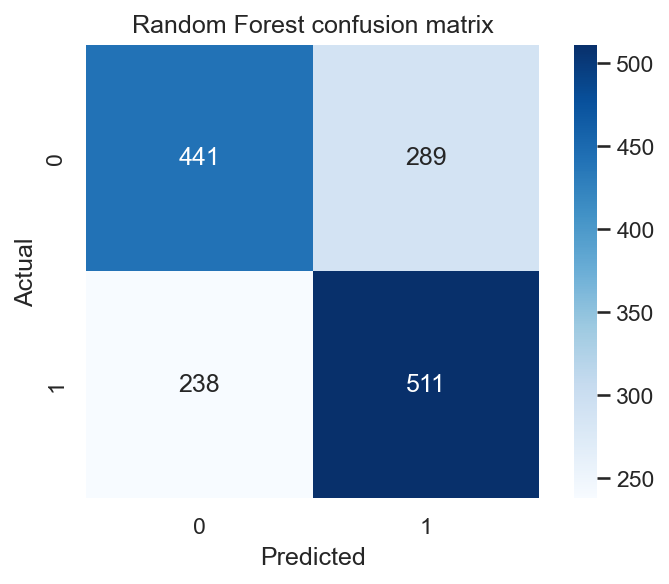

In [71]:
rf_confusion = confusion_matrix(y_test, randomforest.predict(X_test))
plt.figure(dpi=150)
sns.heatmap(rf_confusion, cmap=plt.cm.Blues, annot=True, square=True,fmt="d")

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest confusion matrix');



### XGBoost

In [72]:
from sklearn.metrics import accuracy_score

In [73]:
param_test2 = {
 'max_depth':[4,5,6],
 'min_child_weight':[4,5,6]
}
gsearch2 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate=0.1, n_estimators=40, max_depth=5,
min_child_weight=2, gamma=20, subsample=0.8, colsample_bytree=0.8,
objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
param_grid = param_test2, scoring='accuracy',n_jobs=4, cv=5)
gsearch2.fit(X_train,y_train)
gsearch2.best_params_, gsearch2.best_score_

({'max_depth': 5, 'min_child_weight': 4}, 0.6448621804391036)

In [74]:
xgb0= xgb.XGBClassifier( learning_rate=0.06, n_estimators=1800, max_depth=6,
min_child_weight=5, gamma=25, subsample=0.84, colsample_bytree=0.84,
objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27)


val_accuracy = cross_val_score(xgb0 , X_train, y_train, cv=5, scoring='accuracy')
val_precision=cross_val_score(xgb0 , X_train, y_train, cv=5, scoring='precision')
val_recall=cross_val_score(xgb0 , X_train, y_train, cv=5, scoring='recall')
val_f1=cross_val_score(xgb0, X_train, y_train, cv=5, scoring='f1')
val_roc_auc=cross_val_score(xgb0 , X_train, y_train, cv=5, scoring='roc_auc')
print("The accuracy score for Random Forest Tree is")
print("Validation Accuracy: {:6.2f}%".format(100*val_accuracy.mean()))
print("Validation Recall: {:6.2f}%".format(100*val_recall.mean()))
print("Validation Precison: {:6.2f}%".format(100*val_precision.mean()))
print("Validation F1: {:6.2f}%".format(100*val_f1.mean()))
print("Validation ROC_AUC: {:6.2f}%".format(100*val_roc_auc.mean()))

xgb0.fit(X_train,y_train)
print("The accuracy score for rf is")
print("Training: {:6.2f}%".format(100*xgb0.score(X_train, y_train)))
print("Test set: {:6.2f}%".format(100*xgb0.score(X_test, y_test)))
print("Logistic regression confusion matrix: \n\n", confusion_matrix(y_test, xgb0.predict(X_test)))
y_predict = xgb0.predict(X_train)
print("Default threshold:")
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_train, y_predict), 
                                                     recall_score(y_train, y_predict)))
print(f1_score(y_train, y_predict))
print("ROC AUC score = ", roc_auc_score(y_train, xgb0.predict_proba(X_train)[:,1]))

The accuracy score for Random Forest Tree is
Validation Accuracy:  64.96%
Validation Recall:  69.68%
Validation Precison:  64.89%
Validation F1:  67.19%
Validation ROC_AUC:  70.20%
The accuracy score for rf is
Training:  67.77%
Test set:  64.57%
Logistic regression confusion matrix: 

 [[449 281]
 [243 506]]
Default threshold:
Precision: 0.6770,   Recall: 0.7155
0.6957076751236636
ROC AUC score =  0.7433362735981417


In [75]:
df[df['is_evergreen']==1].url

1       http://www.popsci.com/technology/article/2012-...
2       http://www.menshealth.com/health/flu-fighting-...
3       http://www.dumblittleman.com/2007/12/10-foolpr...
6       http://gofashionlane.blogspot.tw/2012/06/ameri...
8       http://www.valetmag.com/the-handbook/features/...
                              ...                        
7384    http://iammommy.typepad.com/i_am_baker/2011/02...
7386    http://slice.seriouseats.com/archives/2010/06/...
7387    http://achicdirection.com/2012/01/23/vintage-f...
7392    http://eatthis.menshealth.com/slide/sweet-pota...
7393                            http://naturallyella.com/
Name: url, Length: 3796, dtype: object

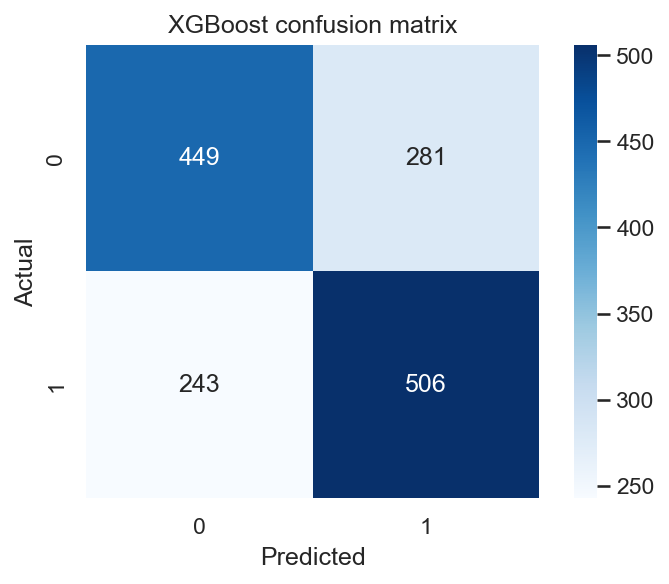

In [76]:
xgb_confusion = confusion_matrix(y_test, xgb0.predict(X_test))
plt.figure(dpi=150)
sns.heatmap(xgb_confusion, cmap=plt.cm.Blues, annot=True, square=True,fmt="d")

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('XGBoost confusion matrix');

### Baseline ROC_AUC Comparaison

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


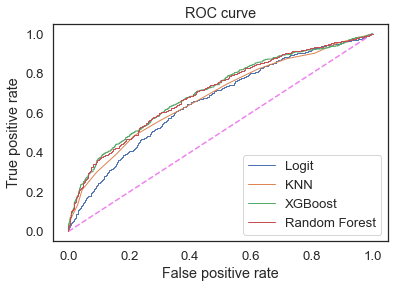

In [77]:
sns.set(context='notebook', style='white',font_scale=1.2)
fpr, tpr, thresholds = roc_curve(y_test, logit2.predict_proba(X_test_scaled)[:,1])
plt.plot(fpr, tpr,lw=1,label='Logit')
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
fpr2, tpr2, thresholds2 = roc_curve(y_test, knn.predict_proba(X_test_scaled)[:,1])
plt.plot(fpr2, tpr2,lw=1,label='KNN')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.legend()
fpr4, tpr4, thresholds4 = roc_curve(y_test, xgb0.predict_proba(X_test)[:,1])
plt.plot(fpr4, tpr4,lw=1,label='XGBoost')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.legend()

fpr3, tpr3, thresholds3 = roc_curve(y_test, randomforest.predict_proba(X_test)[:,1])
plt.plot(fpr3, tpr3,lw=1,label='Random Forest')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.legend()

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');
plt.savefig("myimage8.eps", dpi=1200)

### Check for class imbalance

In [78]:
target_distribution=df.is_evergreen.value_counts(normalize=True)

/Users/riwasabri/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


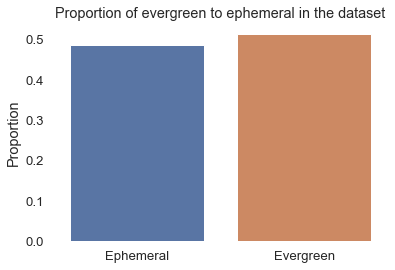

In [79]:
sns.barplot(target_distribution.index,target_distribution.values)
for pos in ['right', 'top', 'bottom', 'left']:
    plt.gca().spines[pos].set_visible(False)
plt.title('Proportion of evergreen to ephemeral in the dataset')
plt.xticks([0, 1], ['Ephemeral', 'Evergreen'])
plt.ylabel('Proportion')
plt.savefig("myimage2.eps", dpi=1200)

In [80]:
#pretty much balanced with positive more frequent, which is convenient!

# Feature Engineering

### Adding categoricals: alchemy_category 

In [81]:
def evaluation(X,y,model,scale=True):
    y=y
    X=X
    
    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.2, random_state=42)
    
    if scale==True:
        std_scale = StandardScaler()

        X_train_scaled = std_scale.fit_transform(X_train)
        X_test_scaled = std_scale.fit_transform(X_test)

        #cross_val_scores

        val_accuracy = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
        val_precision=cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='precision')
        val_recall=cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='recall')
        val_f1=cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='f1')
        val_roc_auc=cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='roc_auc')

        #train_scores

        model.fit(X_train_scaled, y_train)
        train_accuracy=100*model.score(X_train_scaled, y_train)
        y_predict = model.predict(X_train_scaled)
        train_precision=precision_score(y_train, y_predict)
        train_recall=recall_score(y_train, y_predict)
        train_f1=f1_score(y_train, y_predict)
        train_roc_auc=roc_auc_score(y_train, model.predict_proba(X_train_scaled)[:,1])
        
        #test_scores
        test_accuracy=100*model.score(X_test_scaled, y_test)
        y_predict_test = model.predict(X_test_scaled)
        test_precision=precision_score(y_test, y_predict_test)
        test_recall=recall_score(y_test, y_predict_test)
        test_f1=f1_score(y_test, y_predict_test)
        test_roc_auc=roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:,1])
        
    elif scale==False:
        #cross_val_scores

        val_accuracy = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
        val_precision=cross_val_score(model, X_train, y_train, cv=5, scoring='precision')
        val_recall=cross_val_score(model, X_train, y_train, cv=5, scoring='recall')
        val_f1=cross_val_score(model, X_train, y_train, cv=5, scoring='f1')
        val_roc_auc=cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')

        #train_scores

        model.fit(X_train, y_train)
        train_accuracy=100*model.score(X_train, y_train)
        y_predict = model.predict(X_train)
        train_precision=precision_score(y_train, y_predict)
        train_recall=recall_score(y_train, y_predict)
        train_f1=f1_score(y_train, y_predict)
        train_roc_auc=roc_auc_score(y_train, model.predict_proba(X_train)[:,1])
        
        #test_scores
        test_accuracy=100*model.score(X_test, y_test)
        y_predict_test = model.predict(X_test)
        test_precision=precision_score(y_test, y_predict_test)
        test_recall=recall_score(y_test, y_predict_test)
        test_f1=f1_score(y_test, y_predict_test)
        test_roc_auc=roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    dict={'val_accuracy':100*val_accuracy.mean(),'val_precision':100*val_precision.mean(),\
        'val_recall':100*val_recall.mean(),\
        'val_f1':100*val_f1.mean(),'val_roc_auc':100*val_roc_auc.mean(),\
        'train_accuracy':train_accuracy,'train_precision':100*train_precision,\
        'train_recall':100*train_recall,'train_f1':100*train_f1,'train_roc_auc':100*train_roc_auc,\
        'test_accuracy':test_accuracy,'test_precision':100*test_precision,\
        'test_recall':100*test_recall,'test_f1':100*test_f1,'test_roc_auc':100*test_roc_auc }
    resultdf=pd.DataFrame([dict])
    
    return resultdf
        

        
    
 

In [82]:
from sklearn.naive_bayes import BernoulliNB

In [83]:
#cat for logistic as dummies
df_cat_dummies=pd.get_dummies(df,columns=['alchemy_category','news_front_page','website'],drop_first=True)
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64','uint8']
df_cat_dummies_num= (df_cat_dummies.select_dtypes(include=numerics)).drop(columns=['compression_ratio','image_ratio',\
                                                                                  'embed_ratio','hasDomainLink','lengthyLinkDomain','commonlinkratio_1'])

In [84]:
df_cat_dummies_num.columns

Index(['avglinksize', 'commonlinkratio_2', 'commonlinkratio_3',
       'commonlinkratio_4', 'frameTagRatio', 'html_ratio', 'is_news',
       'linkwordscore', 'non_markup_alphanum_characters', 'numberOfLinks',
       'numwords_in_url', 'parametrizedLinkRatio', 'spelling_errors_ratio',
       'is_evergreen', 'alchemy_category_arts_entertainment',
       'alchemy_category_business', 'alchemy_category_computer_internet',
       'alchemy_category_culture_politics', 'alchemy_category_gaming',
       'alchemy_category_health', 'alchemy_category_law_crime',
       'alchemy_category_recreation', 'alchemy_category_religion',
       'alchemy_category_science_technology', 'alchemy_category_sports',
       'alchemy_category_unknown', 'alchemy_category_weather',
       'news_front_page_1', 'news_front_page_?', 'website_babble',
       'website_bbc', 'website_bleacherreport', 'website_blogspot',
       'website_buzzfeed', 'website_cnn', 'website_collegehumor',
       'website_dailymail', 'website_epi

In [85]:
y_log_cat=df_cat_dummies_num['is_evergreen']
X_log_cat=df_cat_dummies_num.drop(columns=['is_evergreen'])


In [86]:
X_train, X_test, y_train, y_test = train_test_split(X_log_cat, y_log_cat,test_size = 0.2, random_state=42)

In [87]:
std_scale = StandardScaler()

X_train_scaled = std_scale.fit_transform(X_train)
X_test_scaled = std_scale.fit_transform(X_test)

In [88]:
logit3=LogisticRegression(C = 0.5,penalty='l2')

In [89]:
logit3.fit(X_train_scaled,y_train)

LogisticRegression(C=0.5)

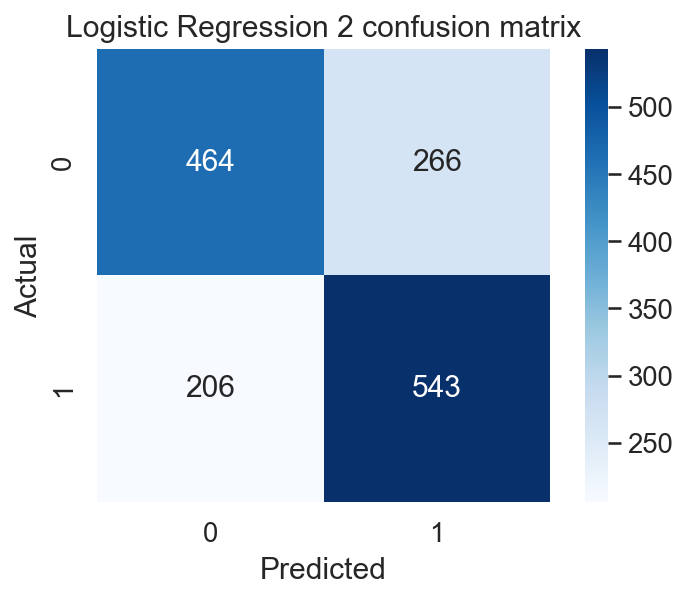

In [90]:
logit_confusion = confusion_matrix(y_test, logit3.predict(X_test_scaled))
plt.figure(dpi=150)
sns.heatmap(logit_confusion, cmap=plt.cm.Blues, annot=True, square=True,fmt="d")

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Logistic Regression 2 confusion matrix');

In [91]:
nb=nb=BernoulliNB()
evaluation(X_log_cat,y_log_cat,nb,False)

,val_accuracy,val_precision,val_recall,val_f1,val_roc_auc,train_accuracy,train_precision,train_recall,train_f1,train_roc_auc,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc
0,64.266081,64.182145,69.214891,66.578645,69.595766,64.705882,64.695066,69.28126,66.909667,70.367873,64.705882,64.169788,68.624833,66.322581,70.103334


### Dummies for Logistic Regression

In [92]:
evaluation(X_log_cat,y_log_cat,LogisticRegression(C = 0.5,penalty='l2'),scale=True)

,val_accuracy,val_precision,val_recall,val_f1,val_roc_auc,train_accuracy,train_precision,train_recall,train_f1,train_roc_auc,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc
0,68.610181,68.36019,72.759267,70.479785,75.254011,69.43881,69.090909,73.580571,71.265099,76.152803,68.086545,67.119901,72.496662,69.70475,74.44227


### One hot encoder for other models

In [93]:
#regular for decision trees
from sklearn.preprocessing import OneHotEncoder

In [94]:
df_cat_rf=df_num.merge(df[['alchemy_category','news_front_page','website']],left_index=True,right_index=True)\
                .drop(columns=['compression_ratio','image_ratio',\
                                                                                  
               'embed_ratio','hasDomainLink','lengthyLinkDomain','commonlinkratio_1'])

In [95]:
encoder = OneHotEncoder(handle_unknown='ignore')

In [96]:
encoder_df = pd.DataFrame(encoder.fit_transform(df_cat_rf[['alchemy_category','news_front_page','website']]).toarray())

In [97]:
final_df = df_cat_rf.join(encoder_df)

In [98]:
final_df.drop('alchemy_category', axis=1, inplace=True)

In [99]:
final_df.drop('news_front_page', axis=1, inplace=True)
final_df.drop('website', axis=1, inplace=True)

In [100]:
X_cat_rf=final_df.drop(columns=['is_evergreen'])
y_cat_rf=final_df['is_evergreen']
X_train, X_test, y_train, y_test = train_test_split(X_cat_rf, y_cat_rf,test_size = 0.2, random_state=42)
    

In [101]:
randomforest2=RandomForestClassifier(n_estimators=600, max_features=4,max_depth=8,bootstrap=True,criterion='entropy',\
                                   min_samples_split=2,class_weight='balanced')

In [102]:
randomforest2.fit(X_train,y_train)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=8, max_features=4, n_estimators=600)

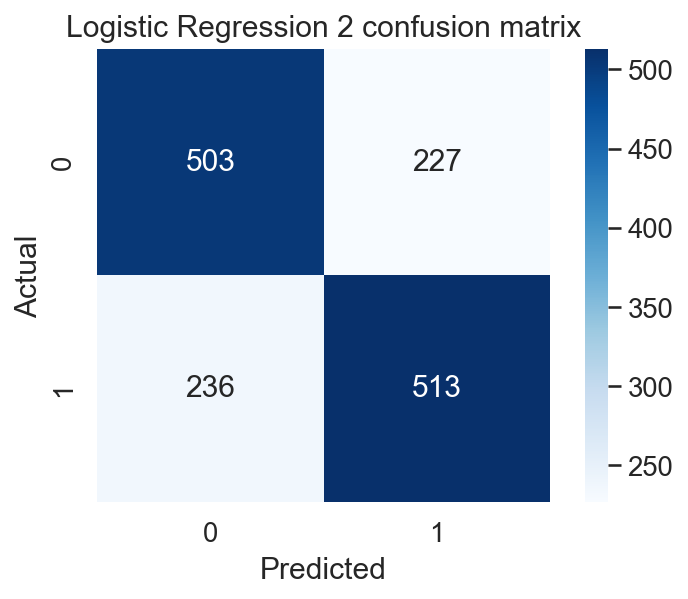

In [103]:
rf_confusion = confusion_matrix(y_test, randomforest2.predict(X_test))
plt.figure(dpi=150)
sns.heatmap(rf_confusion, cmap=plt.cm.Blues, annot=True, square=True,fmt="d")

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Logistic Regression 2 confusion matrix');

In [104]:
'''max_depth=[4,6]
n_estimators = [600,800]
max_features=[4,5]
min_samples_split=[2,4]
bootstrap=[True,False]
criterion=['gini','entropy']
class_weight=['balanced','balanced_'
param_grid= dict(max_depth=max_depth, n_estimators=n_estimators,max_features=max_features,min_samples_split=min_samples_split,bootstrap=bootstrap,criterion=criterion)
# Build the grid search
RF = RandomForestClassifier()
Random_Search = RandomizedSearchCV(RF, param_grid, n_iter=5, cv=5, n_jobs=1, verbose=5)
RandomSearchResults=Random_Search.fit(X_train,y_train)


# Summarize the results in a readable format
print("Best: {0}".format(RandomSearchResults.best_params_))'''


'max_depth=[4,6]\nn_estimators = [600,800]\nmax_features=[4,5]\nmin_samples_split=[2,4]\nbootstrap=[True,False]\ncriterion=[\'gini\',\'entropy\']\nclass_weight=[\'balanced\',\'balanced_\'\nparam_grid= dict(max_depth=max_depth, n_estimators=n_estimators,max_features=max_features,min_samples_split=min_samples_split,bootstrap=bootstrap,criterion=criterion)\n# Build the grid search\nRF = RandomForestClassifier()\nRandom_Search = RandomizedSearchCV(RF, param_grid, n_iter=5, cv=5, n_jobs=1, verbose=5)\nRandomSearchResults=Random_Search.fit(X_train,y_train)\n\n\n# Summarize the results in a readable format\nprint("Best: {0}".format(RandomSearchResults.best_params_))'

In [105]:
randomforest2=RandomForestClassifier(n_estimators=600, max_features=4,max_depth=8,bootstrap=True,criterion='entropy',\
                                   min_samples_split=2,class_weight='balanced')

In [106]:
evaluation(X_cat_rf,y_cat_rf,randomforest2,scale=False)

,val_accuracy,val_precision,val_recall,val_f1,val_roc_auc,train_accuracy,train_precision,train_recall,train_f1,train_roc_auc,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc
0,69.117581,69.823893,70.954427,70.242377,75.79784,75.236646,75.434084,76.993764,76.205944,83.761233,68.424611,69.209809,67.823765,68.509777,74.736727


In [107]:
xgb1 = xgb.XGBClassifier(booster='gblinear',learning_rate=0.3)


In [108]:
'''learning_rate =[0.01,0.02,0.03,0.04]
n_estimators=[600,800]
max_depth=[5
min_child_weight=3
gamma=[20,30]
subsample=0.8
colsample_bytree=1
objective= 'binary:logistic'
nthread=4
scale_pos_weight=1
seed=27
param_grid= dict(max_depth=max_depth, n_estimators=n_estimators,max_features=max_features,min_samples_split=min_samples_split,bootstrap=bootstrap,criterion=criterion)
# Build the grid search
XGB = xgb.XGBClassifier()
Random_Search = RandomizedSearchCV(RF, param_grid, n_iter=5, cv=5, n_jobs=1, verbose=5)
RandomSearchResults=Random_Search.fit(X_train,y_train)


# Summarize the results in a readable format
print("Best: {0}".format(RandomSearchResults.best_params_))'''


'learning_rate =[0.01,0.02,0.03,0.04]\nn_estimators=[600,800]\nmax_depth=[5\nmin_child_weight=3\ngamma=[20,30]\nsubsample=0.8\ncolsample_bytree=1\nobjective= \'binary:logistic\'\nnthread=4\nscale_pos_weight=1\nseed=27\nparam_grid= dict(max_depth=max_depth, n_estimators=n_estimators,max_features=max_features,min_samples_split=min_samples_split,bootstrap=bootstrap,criterion=criterion)\n# Build the grid search\nXGB = xgb.XGBClassifier()\nRandom_Search = RandomizedSearchCV(RF, param_grid, n_iter=5, cv=5, n_jobs=1, verbose=5)\nRandomSearchResults=Random_Search.fit(X_train,y_train)\n\n\n# Summarize the results in a readable format\nprint("Best: {0}".format(RandomSearchResults.best_params_))'

In [109]:
evaluation(X_cat_rf,y_cat_rf,xgb0,scale=False)

,val_accuracy,val_precision,val_recall,val_f1,val_roc_auc,train_accuracy,train_precision,train_recall,train_f1,train_roc_auc,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc
0,68.542871,68.675609,71.610972,70.101797,74.512749,70.537525,71.196359,71.873974,71.533562,77.663543,67.545639,67.81457,68.35781,68.085106,73.976261


In [110]:
evaluation(X_cat_rf,y_cat_rf,xgb1,scale=False)

,val_accuracy,val_precision,val_recall,val_f1,val_roc_auc,train_accuracy,train_precision,train_recall,train_f1,train_roc_auc,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc
0,68.846882,68.621006,72.923632,70.662759,75.259014,69.64165,69.275809,73.777486,71.455817,76.148508,68.086545,67.334168,71.829105,69.509044,74.945041


### Industry Insights Feature Engineering

In [111]:
df_eng_log=df_cat_dummies.copy()
df_eng_rf=final_df.merge(df['url'],left_index=True,right_index=True)

In [112]:
#statistics/report are likely to be ephemeral 
def is_report(url):
    if "report" in url:
        return 1 
    else: 
        return 0
df_eng_log['is_report']=df_eng_log.url.apply(lambda x:is_report(x))
df_eng_rf['is_report']=df_eng_rf.url.apply(lambda x:is_report(x))

#"how to" are most likely to be evergreen 
def is_how_to(whatevs):
    if "ways" in whatevs:
        return 1
    elif "how-to" in whatevs:
        return 1
    else:
        return 0
df_eng_log['is_how_to']=df_eng_log.url.apply(lambda x:is_how_to(x))
df_eng_rf['is_how_to']=df_eng_rf.url.apply(lambda x:is_how_to(x))

# "fashion" 

def is_fashion(url):
    if "fashion" in url:
        return 1
    else:
        return 0
    
df_eng_log['is_fashion']=df_eng_log.url.apply(lambda x:is_fashion(x))
df_eng_rf['is_fashion']=df_eng_rf.url.apply(lambda x:is_fashion(x))
#"recipes" likely to be evergreen
def is_recipe(url):
    if "recipe" in url:
        return 1 
    else:
        return 0
df_eng_log['is_recipe']=df_eng_log.url.apply(lambda x:is_recipe(x)) 
df_eng_rf['is_recipe']=df_eng_rf.url.apply(lambda x:is_recipe(x)) 
def is_tech(url):
    if "tech" in url:
        return 1 
    else:
        return 0
df_eng_log['is_tech']=df_eng_log.url.apply(lambda x:is_tech(x)) 
df_eng_rf['is_tech']=df_eng_rf.url.apply(lambda x:is_tech(x)) 

def is_cook(url):
    if "cook" in url:
        return 1 
    else:
        return 0
df_eng_log['is_cook']=df_eng_log.url.apply(lambda x:is_cook(x)) 
df_eng_rf['is_cook']=df_eng_rf.url.apply(lambda x:is_cook(x)) 

def is_trend(url):
    if "trend" in url:
        return 1 
    else:
        return 0
df_eng_log['is_trend']=df_eng_log.url.apply(lambda x:is_trend(x)) 
df_eng_rf['is_trend']=df_eng_rf.url.apply(lambda x:is_trend(x)) 

In [113]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64','uint8']
df_eng_log= (df_eng_log.select_dtypes(include=numerics)).drop(columns=['compression_ratio','image_ratio',\
                                                                                  'embed_ratio','hasDomainLink','lengthyLinkDomain','commonlinkratio_1'])

In [114]:
df_eng_rf_2=df_eng_rf.drop(columns='url')

In [115]:
#logistic engineered X and Y

In [116]:
X_eng_log=df_eng_log.drop(columns='is_evergreen')
y_eng_log=df_eng_log['is_evergreen']

In [117]:
#other engineered X ans Y 

In [118]:
X_eng_rf=df_eng_rf_2.drop(columns='is_evergreen')
y_eng_rf=df_eng_rf_2['is_evergreen']

In [119]:
X_train, X_test, y_train2, y_test2 = train_test_split(X_eng_log, y_eng_log,test_size = 0.2, random_state=42)
    
std_scale = StandardScaler()

X_train_2 = std_scale.fit_transform(X_train)
X_test_2 = std_scale.fit_transform(X_test)
logit5=LogisticRegression(C = 0.5,penalty='l2',class_weight='balanced')

In [120]:
logit5.fit(X_train_2, y_train2)

print("The score for logistic regression is")
print("Training: {:6.2f}%".format(100*logit5.score(X_train_2, y_train2)))
print("Test set: {:6.2f}%".format(100*logit5.score(X_test_2, y_test2)))
print("Logistic regression confusion matrix: \n\n", confusion_matrix(y_test2, logit5.predict(X_test_2)))

The score for logistic regression is
Training:  73.72%
Test set:  72.82%
Logistic regression confusion matrix: 

 [[550 180]
 [222 527]]


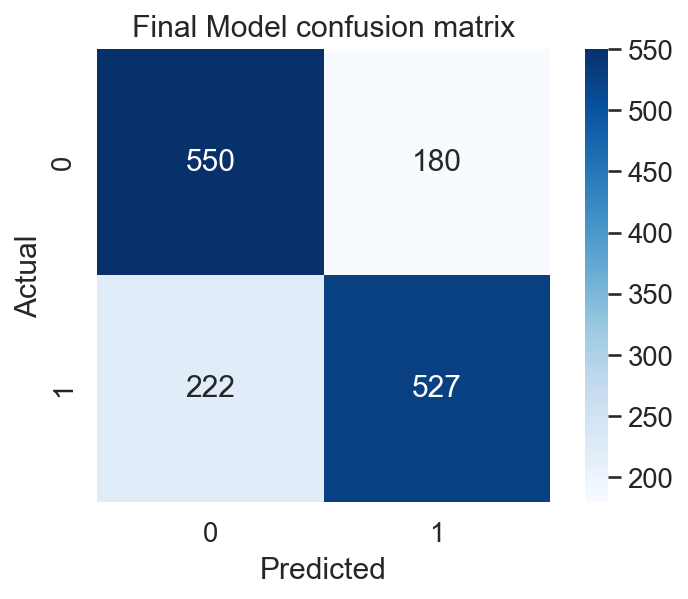

In [121]:
confusion = confusion_matrix(y_test2, logit5.predict(X_test_2))
plt.figure(dpi=150)
sns.heatmap(confusion, cmap=plt.cm.Blues, annot=True, square=True,fmt="d")

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Final Model confusion matrix');

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


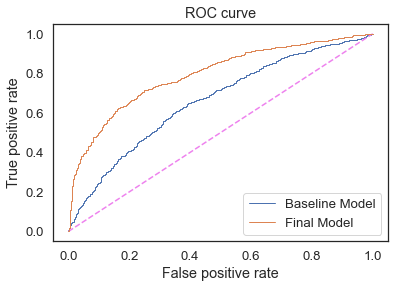

In [122]:

sns.set(context='notebook', style='white',font_scale=1.2)
logit = LogisticRegression(C = 0.05,penalty='l2')
logit.fit(X1_train,y1_train)
fpr, tpr, thresholds = roc_curve(y1_test, logit.predict_proba(X1_test)[:,1])
plt.plot(fpr, tpr,lw=1,label='Baseline Model')
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');
fpr4, tpr4, thresholds4 = roc_curve(y_test2, logit5.predict_proba(X_test_2)[:,1])
plt.plot(fpr4, tpr4,lw=1,label='Final Model')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.legend()

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');
plt.savefig("myimage6.eps", dpi=1200)

### Logistic 

In [123]:
evaluation(X_eng_log,y_eng_log,LogisticRegression(C = 0.5,penalty='l2',class_weight='balanced'),scale=True)

,val_accuracy,val_precision,val_recall,val_f1,val_roc_auc,train_accuracy,train_precision,train_recall,train_f1,train_roc_auc,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc
0,72.700975,74.703164,71.119007,72.859887,79.806683,73.715348,75.635739,72.234985,73.896257,80.677421,72.819473,74.540311,70.360481,72.39011,79.515701


In [124]:
evaluation(X_eng_log,y_eng_log,LogisticRegression(solver='saga',C=0.02,class_weight='balanced'),scale=True)

,val_accuracy,val_precision,val_recall,val_f1,val_roc_auc,train_accuracy,train_precision,train_recall,train_f1,train_roc_auc,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc
0,72.683983,74.730781,71.020431,72.817481,79.798756,73.529412,75.420529,72.103709,73.724832,80.631447,72.819473,74.821173,69.826435,72.237569,79.56874


In [125]:
evaluation(X_eng_log,y_eng_log,LogisticRegression(solver='newton-cg'),scale=True)

,val_accuracy,val_precision,val_recall,val_f1,val_roc_auc,train_accuracy,train_precision,train_recall,train_f1,train_roc_auc,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc
0,72.481123,73.368287,73.186304,73.265077,79.804793,73.546315,74.311024,74.335412,74.323216,80.678176,72.616633,73.369565,72.096128,72.727273,79.47327


### KNN

In [126]:
evaluation(X_eng_rf,y_eng_rf,knn,scale=True)

,val_accuracy,val_precision,val_recall,val_f1,val_roc_auc,train_accuracy,train_precision,train_recall,train_f1,train_roc_auc,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc
0,70.165178,71.601058,69.838811,70.687026,77.60897,74.492901,75.770777,74.204135,74.979274,82.389675,70.723462,71.643836,69.826435,70.723462,77.544489


### Random Forest

In [127]:
evaluation(X_eng_rf,y_eng_rf,randomforest,scale=False)

,val_accuracy,val_precision,val_recall,val_f1,val_roc_auc,train_accuracy,train_precision,train_recall,train_f1,train_roc_auc,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc
0,71.484031,73.325533,70.626396,71.838696,79.031493,73.613928,75.585399,72.03807,73.769114,81.645203,71.196755,73.715125,67.022697,70.20979,77.840957


In [128]:
evaluation(X_eng_rf,y_eng_rf,randomforest2,scale=False)

,val_accuracy,val_precision,val_recall,val_f1,val_roc_auc,train_accuracy,train_precision,train_recall,train_f1,train_roc_auc,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc
0,72.582746,74.407474,71.578508,72.747936,79.773761,76.352265,78.199863,74.991795,76.562238,85.346808,71.602434,73.944687,67.823765,70.752089,78.567954


### XG Boost

In [129]:
xgb2=xgb.XGBClassifier(learning_rate=1.1, n_estimators=240, max_depth=5,
min_child_weight=2, gamma=20, subsample=0.8, colsample_bytree=0.8,
objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27)

In [130]:
xgb1 = xgb.XGBClassifier(
 learning_rate =0.04,
 n_estimators=800,
 max_depth=5,
 min_child_weight=3,
 gamma=20,
 subsample=0.8,
 colsample_bytree=1,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)


In [131]:
xgb3=xgb.XGBClassifier(
 learning_rate =0.9,booster='gblinear')

In [132]:
evaluation(X_eng_rf,y_eng_rf,xgb0,scale=False)

,val_accuracy,val_precision,val_recall,val_f1,val_roc_auc,train_accuracy,train_precision,train_recall,train_f1,train_roc_auc,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc
0,71.179762,73.298765,69.347008,71.248717,78.968445,73.444895,75.714286,71.316049,73.449383,81.158035,71.467208,73.323823,68.624833,70.896552,78.505679


In [133]:
evaluation(X_eng_rf,y_eng_rf,xgb1,scale=False)

,val_accuracy,val_precision,val_recall,val_f1,val_roc_auc,train_accuracy,train_precision,train_recall,train_f1,train_roc_auc,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc
0,71.348867,73.411124,69.609895,71.445336,79.258069,74.002705,75.689479,72.957007,74.298128,81.770131,71.399594,73.153409,68.758344,70.887818,78.609927


In [134]:
evaluation(X_eng_rf,y_eng_rf,xgb2,scale=False)

,val_accuracy,val_precision,val_recall,val_f1,val_roc_auc,train_accuracy,train_precision,train_recall,train_f1,train_roc_auc,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc
0,71.095089,72.717708,70.330722,71.48642,78.360477,74.273158,75.374376,74.335412,74.851289,81.932374,71.264368,72.191781,70.360481,71.264368,77.778865


In [135]:
evaluation(X_eng_rf,y_eng_rf,xgb3,scale=False)

,val_accuracy,val_precision,val_recall,val_f1,val_roc_auc,train_accuracy,train_precision,train_recall,train_f1,train_roc_auc,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc
0,72.514936,73.355001,73.219145,73.310809,79.808707,73.546315,74.326986,74.302593,74.314787,80.681757,73.089926,74.074074,72.096128,73.071719,79.732063


In [136]:
model_list=[('rf',randomforest2),('xgboost',xgb3),('knn',knn)]

In [137]:
from sklearn.ensemble import VotingClassifier

In [138]:
vc=VotingClassifier(estimators=model_list,voting='hard',weights=None)

In [139]:
X_train, X_test, y_train, y_test = train_test_split(X_eng_rf, y_eng_rf,test_size = 0.2, random_state=42)

In [140]:
vc.fit(X_train,y_train)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(class_weight='balanced',
                                                     criterion='entropy',
                                                     max_depth=8,
                                                     max_features=4,
                                                     n_estimators=600)),
                             ('xgboost',
                              XGBClassifier(base_score=0.5, booster='gblinear',
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metr...
                      

In [141]:
def evaluation2(X,y,model,scale=True):
    y=y
    X=X
    
    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.2, random_state=42)
    
    if scale==True:
        std_scale = StandardScaler()

        X_train_scaled = std_scale.fit_transform(X_train)
        X_test_scaled = std_scale.fit_transform(X_test)

        #cross_val_scores

        val_accuracy = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
        val_precision=cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='precision')
        val_recall=cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='recall')
        val_f1=cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='f1')
        val_roc_auc=cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='roc_auc')

        #train_scores

        model.fit(X_train_scaled, y_train)
        train_accuracy=100*model.score(X_train_scaled, y_train)
        y_predict = model.predict(X_train_scaled)
        train_precision=precision_score(y_train, y_predict)
        train_recall=recall_score(y_train, y_predict)
        train_f1=f1_score(y_train, y_predict)
        train_roc_auc=roc_auc_score(y_train, model.predict_proba(X_train_scaled)[:,1])
        
        #test_scores
        test_accuracy=100*model.score(X_test_scaled, y_test)
        y_predict_test = model.predict(X_test_scaled)
        test_precision=precision_score(y_test, y_predict_test)
        test_recall=recall_score(y_test, y_predict_test)
        test_f1=f1_score(y_test, y_predict_test)
        test_roc_auc=roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:,1])
        
    elif scale==False:
        #cross_val_scores

        val_accuracy = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
        val_precision=cross_val_score(model, X_train, y_train, cv=5, scoring='precision')
        val_recall=cross_val_score(model, X_train, y_train, cv=5, scoring='recall')
        val_f1=cross_val_score(model, X_train, y_train, cv=5, scoring='f1')
        val_roc_auc=cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')

        #train_scores

        model.fit(X_train, y_train)
        train_accuracy=100*model.score(X_train, y_train)
        y_predict = model.predict(X_train)
        train_precision=precision_score(y_train, y_predict)
        train_recall=recall_score(y_train, y_predict)
        train_f1=f1_score(y_train, y_predict)
        #train_roc_auc=roc_auc_score(y_train, model.predict_proba(X_train)[:,1])
        
        #test_scores
        test_accuracy=100*model.score(X_test, y_test)
        y_predict_test = model.predict(X_test)
        test_precision=precision_score(y_test, y_predict_test)
        test_recall=recall_score(y_test, y_predict_test)
        test_f1=f1_score(y_test, y_predict_test)
        #test_roc_auc=roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    dict={'val_accuracy':100*val_accuracy.mean(),'val_precision':100*val_precision.mean(),\
        'val_recall':100*val_recall.mean(),\
        'val_f1':100*val_f1.mean(),'val_roc_auc':100*val_roc_auc.mean(),\
        'train_accuracy':train_accuracy,'train_precision':100*train_precision,\
        'train_recall':100*train_recall,'train_f1':100*train_f1,\
        'test_accuracy':test_accuracy,'test_precision':100*test_precision,\
        'test_recall':100*test_recall,'test_f1':100*test_f1}
    resultdf=pd.DataFrame([dict])
    
    return resultdf
        

        
    
 

In [142]:
vc.score(X_eng_rf,y_eng_rf)

0.7510480054090601

In [143]:
evaluation2(X_eng_rf,y_eng_rf,vc,scale=False)

/Users/riwasabri/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/riwasabri/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 334, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "/Users/riwasabri/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 53, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'VotingClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/riwasabri/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/riwasabri/opt/anacond

,val_accuracy,val_precision,val_recall,val_f1,val_roc_auc,train_accuracy,train_precision,train_recall,train_f1,test_accuracy,test_precision,test_recall,test_f1
0,72.210796,73.587591,72.464777,72.863832,NaN,75.828262,77.194753,75.319987,76.245847,72.481406,74.152542,70.093458,72.065889


In [144]:
!pip install yellowbrick

In [145]:
!conda install -c districtdatalabs yellowbrick

Solving environment: done

## Package Plan ##

  environment location: /Users/riwasabri/opt/anaconda3/envs/classification

  added / updated specs:
    - yellowbrick


The following packages will be SUPERSEDED by a higher-priority channel:

  openssl            conda-forge::openssl-1.1.1q-hfe4f2af_0 --> pkgs/main::openssl-1.1.1q-hca72f7f_0


Proceed ([y]/n)? ^C

CondaSystemExit: 
Operation aborted.  Exiting.



In [146]:
!pip install yellowbrick

In [147]:
! pip install yellowbrick

In [593]:
df['text'][0]

'"A sign stands outside the International Business Machines Corp IBM Almaden Research Center campus in San Jose California Photographer Tony Avelar Bloomberg Buildings stand at the International Business Machines Corp IBM Almaden Research Center campus in the Santa Teresa Hills of San Jose California Photographer Tony Avelar Bloomberg By 2015 your mobile phone will project a 3 D image of anyone who calls and your laptop will be powered by kinetic energy At least that s what International Business Machines Corp sees in its crystal ball The predictions are part of an annual tradition for the Armonk New York based company which surveys its 3 000 researchers to find five ideas expected to take root in the next five years IBM the world s largest provider of computer services looks to Silicon Valley for input gleaning many ideas from its Almaden research center in San Jose California Holographic conversations projected from mobile phones lead this year s list The predictions also include air

### Confusion Matrices

### TF-IDF

In [432]:
import numpy as np 
import pandas as pd 
import re
import nltk 
import matplotlib.pyplot as plt

In [433]:
def return_text(boilerplate):
    return boilerplate.split(':')[2].replace('url','')

In [434]:
df['text']=df.boilerplate.apply(lambda x:return_text(x))

In [435]:
features=df['text']
labels=df['is_evergreen']

In [436]:
processed_features = []

for sentence in range(0, len(features)):
    # Remove all the special characters
    processed_feature = re.sub(r'\W', ' ', str(features[sentence]))

    # remove all single characters
    processed_feature= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature)

    # Remove single characters from the start
    processed_feature = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_feature) 

    # Substituting multiple spaces with single space
    processed_feature = re.sub(r'\s+', ' ', processed_feature, flags=re.I)

    # Removing prefixed 'b'
    processed_feature = re.sub(r'^b\s+', '', processed_feature)

    # Converting to Lowercase
    processed_feature = processed_feature.lower()

    processed_features.append(processed_feature)

In [437]:
import nltk
nltk.download('stopwords')
  

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/riwasabri/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Merging features with logistic 

In [565]:
#from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords

In [566]:
df['processed']=processed_features

In [567]:
df2=df['processed']

In [568]:
X_train_idx, X_test_idx, y_train, y_test = train_test_split(range(0, len(df2)), labels, test_size=0.2, random_state=42)

In [569]:
processed_features_train = [processed_features[i] for i in X_train_idx]
processed_features_test = [processed_features[i] for i in X_test_idx]

In [570]:
vectorizer = TfidfVectorizer (max_features=1000, min_df=6, max_df=0.7, stop_words=stopwords.words('english'),\
                             norm='l1')
processed_features_train = vectorizer.fit_transform(processed_features_train).toarray()
processed_features_test = vectorizer.transform(processed_features_test).toarray()

In [571]:
processed_features_train

array([[0.        , 0.00287135, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [572]:
#Logistic dataset

In [573]:
X_eng_log_train = X_eng_log.iloc[X_train_idx]

In [574]:
X_eng_log_train_np = np.array(X_eng_log_train)

In [575]:
X_eng_log_train_np.shape

(5916, 58)

In [576]:
final_X_train_idx= np.hstack((X_eng_log_train_np, processed_features_train))

In [577]:
X_eng_log_test = X_eng_log.iloc[X_test_idx]
X_eng_log_test_np = np.array(X_eng_log_test)
final_X_test_idx= np.hstack((X_eng_log_test_np, processed_features_test))

In [588]:
model=LogisticRegression(C=0.0005,solver='saga')

In [589]:
std_scale = StandardScaler()

X_train_scaled = std_scale.fit_transform(final_X_train_idx)
X_test_scaled = std_scale.fit_transform(final_X_test_idx)

#cross_val_scores

val_accuracy = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
val_precision=cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='precision')
val_recall=cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='recall')
val_f1=cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='f1')
val_roc_auc=cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='roc_auc')

#train_scores

model.fit(X_train_scaled, y_train)
train_accuracy=100*model.score(X_train_scaled, y_train)
y_predict = model.predict(X_train_scaled)
train_precision=precision_score(y_train, y_predict)
train_recall=recall_score(y_train, y_predict)
train_f1=f1_score(y_train, y_predict)
train_roc_auc=roc_auc_score(y_train, model.predict_proba(X_train_scaled)[:,1])
        
#test_scores
test_accuracy=100*model.score(X_test_scaled, y_test)
y_predict_test = model.predict(X_test_scaled)
test_precision=precision_score(y_test, y_predict_test)
test_recall=recall_score(y_test, y_predict_test)
test_f1=f1_score(y_test, y_predict_test)
test_roc_auc=roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:,1])
        

In [590]:
dict={'val_accuracy':100*val_accuracy.mean(),'val_precision':100*val_precision.mean(),\
        'val_recall':100*val_recall.mean(),\
        'val_f1':100*val_f1.mean(),'val_roc_auc':100*val_roc_auc.mean(),\
        'train_accuracy':train_accuracy,'train_precision':100*train_precision,\
        'train_recall':100*train_recall,'train_f1':100*train_f1,'train_roc_auc':100*train_roc_auc,\
        'test_accuracy':test_accuracy,'test_precision':100*test_precision,\
        'test_recall':100*test_recall,'test_f1':100*test_f1,'test_roc_auc':100*test_roc_auc }
resultdf=pd.DataFrame([dict])

In [591]:
resultdf

,val_accuracy,val_precision,val_recall,val_f1,val_roc_auc,train_accuracy,train_precision,train_recall,train_f1,train_roc_auc,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc
0,78.110179,84.576305,70.364101,76.809653,85.279949,82.031778,88.360402,74.991795,81.129061,90.296165,78.634212,84.64,70.627503,77.001456,85.178229


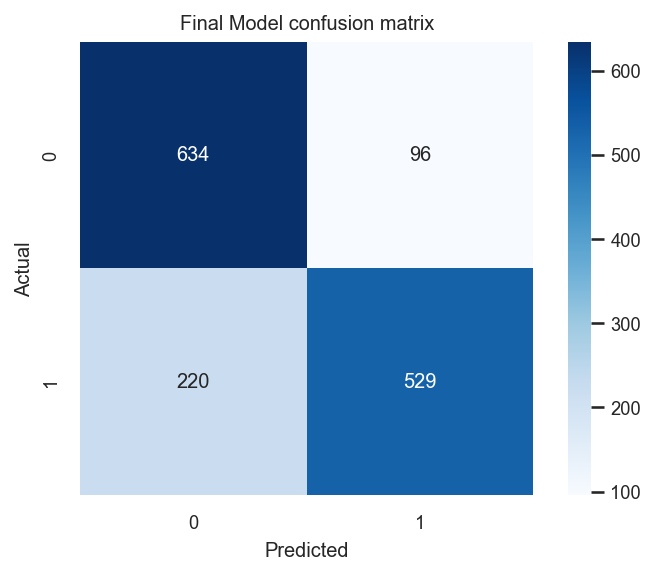

In [598]:
sns.set(font_scale=0.8)
confusion = confusion_matrix(y_test, model.predict(X_test_scaled))
plt.figure(dpi=150)
sns.heatmap(confusion, cmap=plt.cm.Blues, annot=True, square=True,fmt="d")

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Final Model confusion matrix');

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


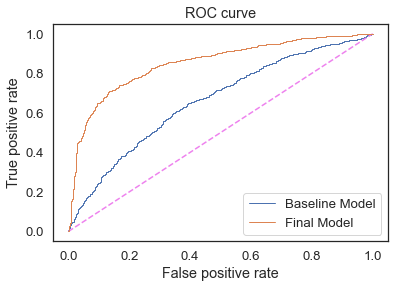

In [601]:

sns.set(context='notebook', style='white',font_scale=1.2)
logit = LogisticRegression(C = 0.05,penalty='l2')
logit.fit(X1_train,y1_train)
fpr, tpr, thresholds = roc_curve(y1_test, logit.predict_proba(X1_test)[:,1])
plt.plot(fpr, tpr,lw=1,label='Baseline Model')
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');
fpr4, tpr4, thresholds4 = roc_curve(y_test, model.predict_proba(X_test_scaled)[:,1])
plt.plot(fpr4, tpr4,lw=1,label='Final Model')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.legend()

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');
plt.savefig("myimage10.eps", dpi=1200)

In [506]:
#RF and other dataset

In [507]:
X_eng_rf_train = X_eng_rf.iloc[X_train_idx]
X_eng_rf_train_np = np.array(X_eng_rf_train)
final_X_train_rf_idx= np.hstack((X_eng_rf_train_np, processed_features_train))
X_eng_rf_test = X_eng_rf.iloc[X_test_idx]
X_eng_rf_test_np = np.array(X_eng_rf_test)
final_X_test_rf_idx= np.hstack((X_eng_rf_test_np, processed_features_test))

In [582]:
model=xgb0

In [583]:
std_scale = StandardScaler()

X_train= final_X_train_rf_idx
X_test = final_X_test_rf_idx

#cross_val_scores

val_accuracy = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
val_precision=cross_val_score(model, X_train, y_train, cv=5, scoring='precision')
val_recall=cross_val_score(model, X_train, y_train, cv=5, scoring='recall')
val_f1=cross_val_score(model, X_train, y_train, cv=5, scoring='f1')
val_roc_auc=cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')

#train_scores

model.fit(X_train, y_train)
train_accuracy=100*model.score(X_train, y_train)
y_predict = model.predict(X_train)
train_precision=precision_score(y_train, y_predict)
train_recall=recall_score(y_train, y_predict)
train_f1=f1_score(y_train, y_predict)
train_roc_auc=roc_auc_score(y_train, model.predict_proba(X_train)[:,1])
        
#test_scores
test_accuracy=100*model.score(X_test, y_test)
y_predict_test = model.predict(X_test)
test_precision=precision_score(y_test, y_predict_test)
test_recall=recall_score(y_test, y_predict_test)
test_f1=f1_score(y_test, y_predict_test)
test_roc_auc=roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
        

KeyboardInterrupt: 

In [ ]:
dict={'val_accuracy':100*val_accuracy.mean(),'val_precision':100*val_precision.mean(),\
        'val_recall':100*val_recall.mean(),\
        'val_f1':100*val_f1.mean(),'val_roc_auc':100*val_roc_auc.mean(),\
        'train_accuracy':train_accuracy,'train_precision':100*train_precision,\
        'train_recall':100*train_recall,'train_f1':100*train_f1,'train_roc_auc':100*train_roc_auc,\
        'test_accuracy':test_accuracy,'test_precision':100*test_precision,\
        'test_recall':100*test_recall,'test_f1':100*test_f1,'test_roc_auc':100*test_roc_auc }
resultdf=pd.DataFrame([dict])

In [ ]:
resultdf